# VGG16

## Convolutional neural networks for artistic style transfer


In [5]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/STAT6289/Final/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from __future__ import print_function

from PIL import Image
import numpy as np

#keras libraries
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


## Load and preprocess the images


In [7]:
def load_show_resize(path):
  target=Image.open(path)
  target=target.resize((512,512))
  return target


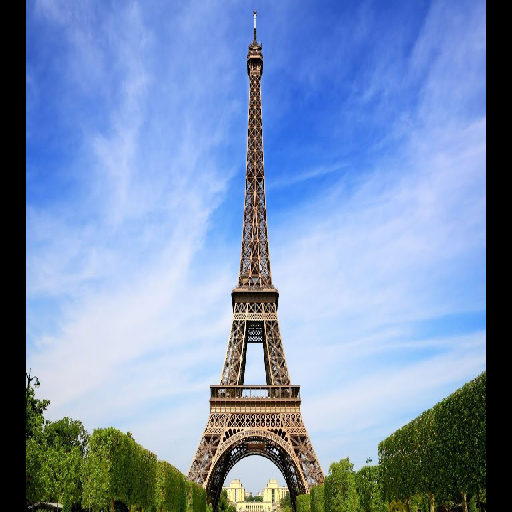

In [8]:
content_image = load_show_resize(abspath_curr+'tower.jpg')
# #preview content image
content_image

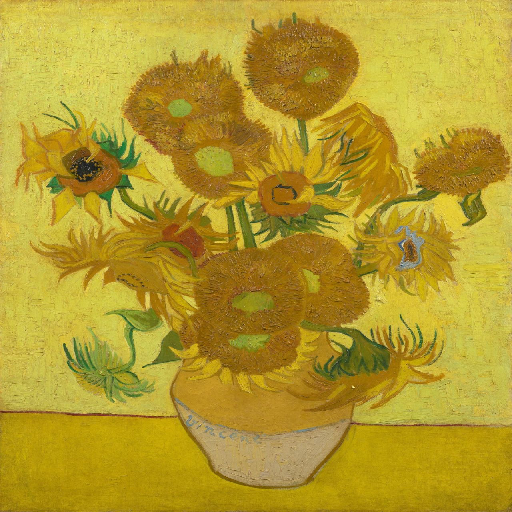

In [9]:
style_image = load_show_resize(abspath_curr+'flower.jpg')

#preview style image
style_image

convert both images into an array, add another dimension, convenient for later concatenating. 

In [10]:
def convert_image(image):
  image_array=np.asarray(image, dtype='float32')
  image_array = np.expand_dims(image_array, axis=0)
  print ("The shape of this image array is:",image_array.shape)
  return image_array

In [11]:
content_array=convert_image(content_image)

The shape of this image array is: (1, 512, 512, 3)


In [12]:
style_array=convert_image(style_image)

The shape of this image array is: (1, 512, 512, 3)


## Preprocess data

Perform the same preprocessing process as are expected according to the VGG training process.


*   Normalization: Subtract the mean RGB value.
*   Change from *RGB* to *BGR* 



In [13]:
#RGB value is available online which are 103.939, 116.779, 123.68
def sub_RGB(image_array):
  image_array[:, :, :, 0] -= 103.939
  image_array[:, :, :, 1] -= 116.779
  image_array[:, :, :, 2] -= 123.68
  return image_array

In [14]:
def inverse_array(image_array):
  image_array=image_array[:, :, :, ::-1]
  print("The shape of this image array is:",content_array.shape)
  return image_array

In [15]:
content_array=sub_RGB(content_array)
content_array=inverse_array(content_array)

The shape of this image array is: (1, 512, 512, 3)


In [16]:
style_array=sub_RGB(style_array)
style_array=inverse_array(style_array)

The shape of this image array is: (1, 512, 512, 3)


Create a placeholder variable to store the *combination* image that retains the content of the content image while incorporating the style of the style image.

In [17]:
#define a function to create placeholder for images
def placeholder(image_array):
  image=backend.variable(image_array)
  return image


In [18]:
content_image=placeholder(content_array)
style_image=placeholder(style_array)

In [19]:
# Creating a placeholder for the combined image:
height = 512
width = 512
combination_image = backend.placeholder((1, height, width, 3))

Finally, concatenate all this image data into a single tensor and feed it to  Keras' VGG16 model.

In [20]:
input_tensor = backend.concatenate([content_image,style_image,combination_image],axis=0)

Load the model

Note that 'include_top=False' in the code below, we don't include any of the fully connected layers.

In [21]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

58900480/58889256 [==============================] - 2s 0us/step


In [22]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [23]:
model.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(3, 16, 16, 512) dtype=float32>

## Optimizing loss function and styling the image:

In [24]:
 # Creating the dictionary containing all the layers in the model:
 layers = dict([(layer.name, layer.output) for layer in model.layers])

 #check the name for each layers so that we can easily refer for individual layer
 layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [25]:
# Defining alpha and beta for the total loss:
# alpha is content weight while beta is style weight

alpha = 0.05
beta = 5.0
total_variation_weight = 1.0

In [26]:
# Defining the loss variable:

loss = backend.variable(0.)

### The content loss


In [27]:
# Calculating the content loss:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

def in_diff(a,b):
  return (b-a)

content_loss=backend.sum(backend.square(in_diff(content_image_features,combination_features)))

loss = loss + alpha * content_loss

### The style loss



In [28]:
# Defining a function to form the gram matrix:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [29]:
def square(a):
  return a**2

In [30]:
def get_style_loss(style_features, combination_features):
    S = gram_matrix(style_features)
    G = gram_matrix(combination_features)
    channels = 3
    size = width * height
    return backend.sum(backend.square(S - G)) / (4. * square(channels) * square(size))

In [31]:
style_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                   'block5_conv3']

for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = get_style_loss(style_features, combination_features)
    loss += (beta / len(style_layers)) * sl


### The total variation loss



In [32]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss = loss + total_variation_weight * total_variation_loss(combination_image)

### Train model

In [33]:
# Calculating the gradients:
grads = backend.gradients(loss, combination_image)

In [34]:
# Forming the output array and applying the function:

outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [35]:
# Defining a function to get the loss and gradient values:

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [36]:
# Defining the Evaluator class:

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [37]:
# Creating an instance of the class Evaluator:

evaluator = Evaluator()

In [38]:
# Defining the array x and number of iterations:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

# Generating the image:

import time
for i in range(iterations):
    print('Start of iteration', i+1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))

Start of iteration 1
Current loss value: 79662570000.0
Iteration 1 completed in 16s
Start of iteration 2
Current loss value: 30269094000.0
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 24127394000.0
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 21857622000.0
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 21080703000.0
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 20727824000.0
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 20558160000.0
Iteration 7 completed in 6s
Start of iteration 8
Current loss value: 20460468000.0
Iteration 8 completed in 6s
Start of iteration 9
Current loss value: 20398612000.0
Iteration 9 completed in 7s
Start of iteration 10
Current loss value: 20357665000.0
Iteration 10 completed in 7s


### Output

In [39]:
def add_RGB(image_array):
  image_array[:, :, 0] += 103.939
  image_array[:, :, 1] += 116.779
  image_array[:, :, 2] += 123.68
  return image_array

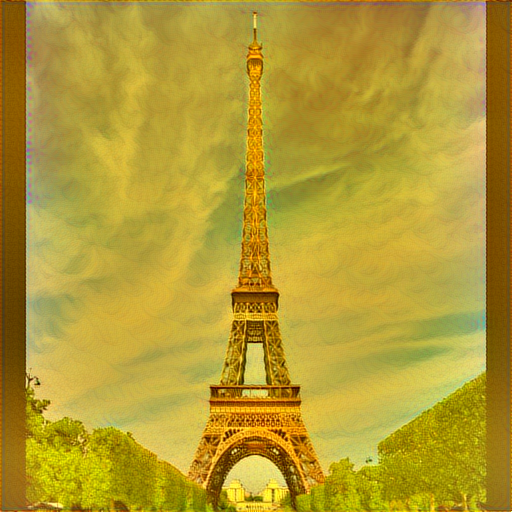

In [40]:
# Reshaping the generated image in a representable form:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x = add_RGB(x)
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

# TF Lite

## Understand the model architecture

![Model Architecture](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/architecture.png)

This Artistic Style Transfer model consists of two submodels:
1. **Style Prediciton Model**: A MobilenetV2-based neural network that takes an input style image to a 100-dimension style bottleneck vector.
1. **Style Transform Model**: A neural network that takes apply a style bottleneck vector to a content image and creates a stylized image.


## Setup

In [41]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import functools

Download the pre-trained TensorFlow Lite models.

In [42]:
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

294912/284398 [===============================] - 0s 0us/step


## Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

In [43]:
# Load the input images.
content_image = tf.io.read_file(abspath_curr + 'tower.jpg')
content_image = tf.io.decode_image(content_image, channels=3)
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
content_image = content_image[tf.newaxis, :]

style_image = tf.io.read_file(abspath_curr + 'flower.jpg')
style_image = tf.io.decode_image(style_image, channels=3)
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
style_image = style_image[tf.newaxis, :]


# Preprocess the input images.
shape = tf.cast(tf.shape(content_image)[1:-1], tf.float32)
short_dim = min(shape)
scale = 384 / short_dim
new_shape = tf.cast(shape * scale, tf.int32)
content_image = tf.image.resize(content_image, new_shape)
content_image = tf.image.resize_with_crop_or_pad(content_image, 384, 384)
preprocessed_content_image = content_image

shape = tf.cast(tf.shape(style_image)[1:-1], tf.float32)
short_dim = min(shape)
scale = 256 / short_dim
new_shape = tf.cast(shape * scale, tf.int32)
style_image = tf.image.resize(style_image, new_shape)
style_image = tf.image.resize_with_crop_or_pad(style_image, 256, 256)
preprocessed_style_image = style_image

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


## Visualize the inputs

In [44]:
def show_image(image, title=None):
  image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  plt.title(title)


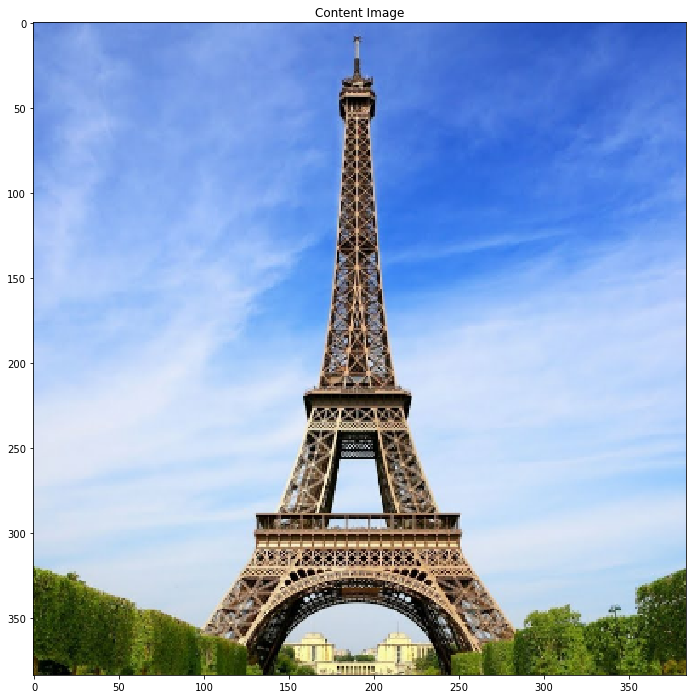

In [45]:
show_image(preprocessed_content_image, 'Content Image')

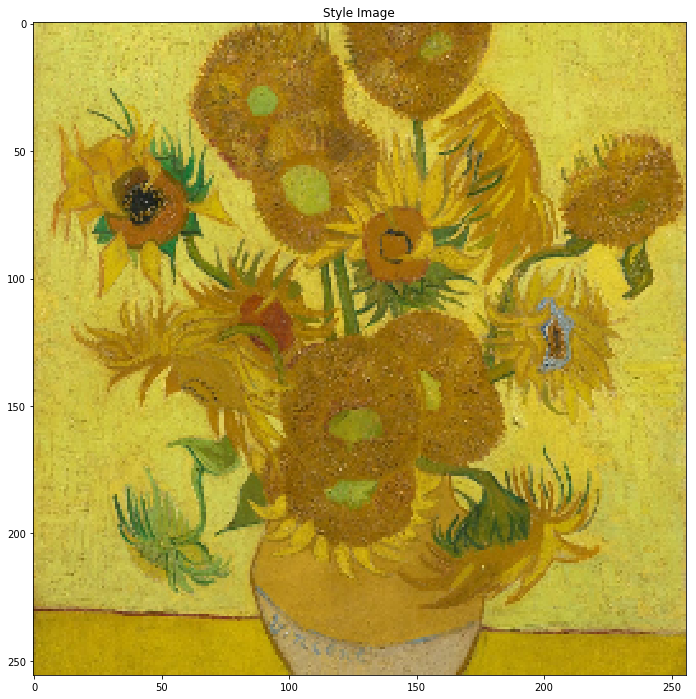

In [46]:
show_image(preprocessed_style_image, 'Style Image')

## Run style transfer with TensorFlow Lite

### Style prediction

In [47]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


### Style transform

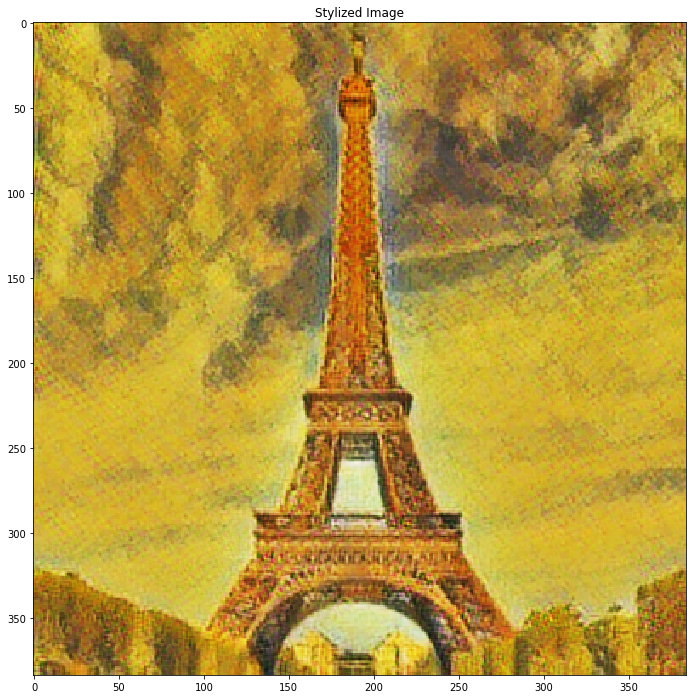

In [48]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

  # Set model inputs.
interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
interpreter.invoke()

  # Transform content image.
stylized_image = interpreter.tensor(interpreter.get_output_details()[0]["index"])()


# Visualize the output.
show_image(stylized_image, 'Stylized Image')